Sistem Rekomendasi Soal - AIZU Online Judge
======================================
Proyek 2 - 2A D4 Teknik Komputer dan Informatika

## Prerequisites

In [18]:
!conda install scikit-learn pandas numpy keras matplotlib -y

Solving environment: done

# All requested packages already installed.



## Implementation

In [1]:
import keras
import keras.callbacks
import keras.layers
import keras.preprocessing.sequence
import keras.utils.np_utils
import matplotlib.pyplot
import numpy
import pandas
import sklearn
import sklearn.cluster
import sklearn.preprocessing

ABILITYCHART_CSV = pandas.read_csv('abilitychart.csv')
ABILITYCHART_CSV = ABILITYCHART_CSV.set_index("userId")
ABILITYCHART_CSV = ABILITYCHART_CSV.sort_values(['solvedNum'], ascending=False)
ABILITYCHART_CSV.loc[:, "Straight Forward":"Tree"] = sklearn.preprocessing.MinMaxScaler().fit_transform(ABILITYCHART_CSV.loc[:,"Straight Forward":"Tree"])

LEARNINGPATH_CSV = pandas.read_csv('learning.csv')
LEARNINGPATH_CSV = LEARNINGPATH_CSV.set_index("userId")
LEARNINGPATH_CSV = LEARNINGPATH_CSV.sort_values(by=['userId', 'submissionDate'])

PROBLEM_CSV = LEARNINGPATH_CSV.loc[:,'problemId'].unique()
PROBLEM_LENGTH = len(PROBLEM_CSV)
PROBLEM_MAP_NAME_TO_INT = dict([(y, x) for x, y in enumerate(PROBLEM_CSV)])
PROBLEM_MAP_INT_TO_NAME = dict([(x, y) for x, y in enumerate(PROBLEM_CSV)])
PROBLEM_STATUS_SOLVED = 4

def get_normal_user(minimal_solvedNum=100):
    return ABILITYCHART_CSV.sort_values(['solvedNum'], ascending=False).loc[ABILITYCHART_CSV['solvedNum'] >= minimal_solvedNum].index.unique().values

def get_candidate_user(target_user):
    target_user_learning_path = LEARNINGPATH_CSV.loc[((LEARNINGPATH_CSV.index == target_user) & (LEARNINGPATH_CSV['status'] == PROBLEM_STATUS_SOLVED)), 'problemId'].values
    return LEARNINGPATH_CSV.loc[(LEARNINGPATH_CSV.index.isin(get_normal_user()) & (LEARNINGPATH_CSV['problemId'].isin(target_user_learning_path)))].index.unique().values

def get_teacher_user(target_user):
    user_ability_chart = ABILITYCHART_CSV.loc[ABILITYCHART_CSV.index.isin(numpy.append(get_candidate_user(target_user), target_user)), 'Straight Forward':'Tree']
    user_ability_chart['cluster'] = sklearn.cluster.KMeans(init='k-means++', n_clusters=8).fit_predict(user_ability_chart.loc[:,"Straight Forward":"Tree"])
    return user_ability_chart[(user_ability_chart.index != target_user) & (user_ability_chart['cluster'] == user_ability_chart.loc[target_user, 'cluster'])].index.unique().values    

def get_teacher_user_learning_path(target_user):
    return LEARNINGPATH_CSV.loc[LEARNINGPATH_CSV.index.isin(get_teacher_user(target_user)) & (LEARNINGPATH_CSV['status'] == 4), 'problemId']

def get_teacher_user_learning_path_raw(target_user):
    teacher_user_learning_path = get_teacher_user_learning_path(target_user)
    return list(map(lambda x: list(map(lambda y: PROBLEM_MAP_NAME_TO_INT[y], teacher_user_learning_path.loc[teacher_user_learning_path.index == x].values)), teacher_user_learning_path.index.unique().values))

def get_training_sample_shape(train_sample):
    train_x = []
    train_y = []
    for learning_path in train_sample:
        if len(learning_path) > 1:
            train_x.append(numpy.array(learning_path[:-1]))
            train_y.append(numpy.array(learning_path[1:]))
    # add padding
    train_x = keras.preprocessing.sequence.pad_sequences(train_x, value=PROBLEM_LENGTH)
    train_y = keras.preprocessing.sequence.pad_sequences(train_y, value=PROBLEM_LENGTH)
    # reshape from (sample, timesteps) to (sample, timesteps, feature)
    train_x = numpy.array(list(map(lambda x: numpy.reshape(x, (x.shape[0], 1)), train_x)))
    train_y = numpy.array(list(map(lambda x: numpy.reshape(x, (x.shape[0], 1)), train_y)))
    return train_x, train_y

def get_training_sample(target_user, train_size=0.70, _timesteps_head=30):
    teacher_user_learning_path_raw = get_teacher_user_learning_path_raw(target_user)
    teacher_count = len(teacher_user_learning_path_raw)
    if _timesteps_head > 0:
        teacher_user_learning_path_raw = list(map(lambda x: x[:_timesteps_head], teacher_user_learning_path_raw))
    train_x, train_y = get_training_sample_shape(teacher_user_learning_path_raw)
    training_count = int(teacher_count * train_size)
    return train_x[0:training_count], train_y[0:training_count], train_x[training_count:teacher_count], train_y[training_count:teacher_count]

def get_lstm_model(units):
    model = keras.Sequential()
    model.add(keras.layers.Masking(mask_value=PROBLEM_LENGTH, input_shape=(None, 1)))
    model.add(keras.layers.LSTM(units, return_sequences=True))
    model.add(keras.layers.Dense(PROBLEM_LENGTH + 1, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
    return model

def visualize_model_history(model_history):
    matplotlib.pyplot.plot(model_history.history['loss'])
    matplotlib.pyplot.plot(model_history.history['val_loss'])
    matplotlib.pyplot.title('model train vs validation loss')
    matplotlib.pyplot.ylabel('loss')
    matplotlib.pyplot.xlabel('epoch')
    matplotlib.pyplot.legend(['train', 'validation'], loc='upper right')
    matplotlib.pyplot.show()

def predict(model, target_user):
    learning_path = list(map(lambda x: PROBLEM_MAP_NAME_TO_INT[x], LEARNINGPATH_CSV.loc[(LEARNINGPATH_CSV.index == target_user) & (LEARNINGPATH_CSV['status'] == PROBLEM_STATUS_SOLVED), 'problemId'].values))
    next_predict = model.predict(numpy.reshape(learning_path, (1, len(learning_path), 1)))
    return list(map(lambda x: PROBLEM_MAP_INT_TO_NAME[x], numpy.setdiff1d(numpy.argsort(next_predict[-1,-1][:-1])[::-1], learning_path)))

Using TensorFlow backend.


## Evaluation

In [3]:
target_user = 'paragon'

filename = 'checkpoint-04-4.5393-4.5104.hdf5'

train_x, train_y, test_x, test_y = get_training_sample(target_user)

model = get_lstm_model(train_x.shape[1])

model_history = None

if filename == None:
    model_history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10, batch_size=1, callbacks = [keras.callbacks.ModelCheckpoint("checkpoint-{epoch:02d}-{loss:.4f}-{val_loss:.4f}.hdf5", save_weights_only=True)])
else:
    model.load_weights(filename)

Train on 778 samples, validate on 334 samples
Epoch 1/10
778/778 [==============================] - 134s 172ms/step - loss: 5.6077 - val_loss: 5.1573
Epoch 2/10
778/778 [==============================] - 155s 199ms/step - loss: 5.0143 - val_loss: 4.8868
Epoch 3/10
778/778 [==============================] - 158s 203ms/step - loss: 4.7396 - val_loss: 4.6616
Epoch 4/10
778/778 [==============================] - 161s 207ms/step - loss: 4.5393 - val_loss: 4.5104
Epoch 5/10
778/778 [==============================] - 122s 157ms/step - loss: 4.3987 - val_loss: 4.4059
Epoch 6/10
778/778 [==============================] - 135s 174ms/step - loss: 4.2886 - val_loss: 4.3322
Epoch 7/10
778/778 [==============================] - 128s 164ms/step - loss: 4.2039 - val_loss: 4.2654
Epoch 8/10
778/778 [==============================] - 131s 169ms/step - loss: 4.1266 - val_loss: 4.2092
Epoch 9/10
778/778 [==============================] - 122s 157ms/step - loss: 4.0624 - val_loss: 4.1762
Epoch 10/10
778/77

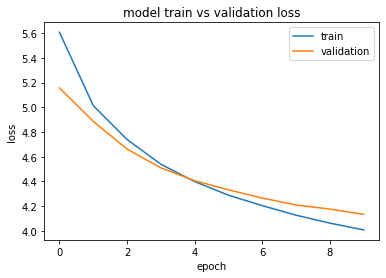

In [4]:
if model_history != None:
    visualize_model_history(model_history)

In [9]:
model.load_weights('checkpoint-04-4.5393-4.5104.hdf5')
predict(model, target_user)[:10]

['ITP1_1_B',
 '1172',
 '0010',
 '0011',
 '0012',
 'DSL_1_A',
 'GRL_1_A',
 'ITP1_1_A',
 'ITP1_1_C',
 '0013']

In [14]:
train_x.shape

(725, 29, 1)

In [16]:
train_y.shape

(725, 29, 1)

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, None, 1)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 29)          3596      
_________________________________________________________________
dense_1 (Dense)              (None, None, 2614)        78420     
Total params: 82,016
Trainable params: 82,016
Non-trainable params: 0
_________________________________________________________________


In [20]:
LEARNINGPATH_CSV

,problemId,submissionDate,status
userId,,,
A027702,ITP1_1_B,1484133387995,4
A0326,1172,1583215065490,2
A0326,1172,1583215522222,4
A0609,ALDS1_1_A,1488980289305,1
A0609,ALDS1_1_A,1488980416777,8
...,...,...,...
zzzz77,ITP1_2_B,1580354071670,4
zzzz77,ITP1_2_C,1580369057453,7
zzzz77,ITP1_2_C,1580369329935,4
